In [1]:
from fastkaggle import *

In [2]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not iskaggle and not cred_path.exists():
    raise Exception('Need to download kaggle credentials')

In [3]:
comp = 'tpu-getting-started'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
classes = ["pink primrose","hard-leaved pocket orchid","canterbury bells","sweet pea","wild geranium","tiger lily","moon orchid","bird of paradise","monkshood","globe thistle","snapdragon","colt's foot","king protea","spear thistle","yellow iris","globe-flower","purple coneflower","peruvian lily","balloon flower","giant white arum lily","fire lily","pincushion flower","fritillary","red ginger","grape hyacinth","corn poppy","prince of wales feathers","stemless gentian","artichoke","sweet william","carnation","garden phlox","love in the mist","cosmos","alpine sea holly","ruby-lipped cattleya","cape flower","great masterwort","siam tulip","lenten rose","barberton daisy","daffodil","sword lily","poinsettia","bolero deep blue","wallflower","marigold","buttercup","daisy","common dandelion","petunia","wild pansy","primula","sunflower","lilac hibiscus","bishop of llandaff","gaura","geranium","orange dahlia","pink-yellow dahlia","cautleya spicata","japanese anemone","black-eyed susan","silverbush","californian poppy","osteospermum","spring crocus","iris","windflower","tree poppy","gazania","azalea","water lily","rose","thorn apple","morning glory","passion flower","lotus","toad lily","anthurium","frangipani","clematis","hibiscus","columbine","desert-rose","tree mallow","magnolia","cyclamen ","watercress","canna lily","hippeastrum ","bee balm","pink quill","foxglove","bougainvillea","camellia","mallow","mexican petunia","bromelia","blanket flower","trumpet creeper","blackberry lily","common tulip","wild rose"]

In [4]:
path

Path('tpu-getting-started')

In [5]:
import timm
import functools
import itertools
from fastai.vision.all import *

path.ls()

(#5) [Path('tpu-getting-started/tfrecords-jpeg-512x512'),Path('tpu-getting-started/tfrecords-jpeg-224x224'),Path('tpu-getting-started/sample_submission.csv'),Path('tpu-getting-started/tfrecords-jpeg-331x331'),Path('tpu-getting-started/tfrecords-jpeg-192x192')]

In [6]:
data_paths = list(filter(lambda x: str(x) != "tpu-getting-started/sample_submission.csv", path.ls()))
data_paths = [Path('tpu-getting-started/tfrecords-jpeg-224x224')]
data_paths = functools.reduce(lambda acc, path: list(itertools.chain(acc, (path/'train').ls(), (path/'val').ls())), data_paths, [])

In [7]:
import tensorflow as tf

data = []
# https://www.tensorflow.org/tutorials/load_data/tfrecord#reading_a_tfrecord_file_in_python
raw_dataset = tf.data.TFRecordDataset(data_paths)

for record in raw_dataset:
    example = tf.train.Example()
    example.ParseFromString(record.numpy())
    datum = [
        example.features.feature['class'].int64_list.value[0],
        example.features.feature['image'].bytes_list.value[0]
    ]
    data.append(datum)

len(data)

2024-07-24 11:29:18.645566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 11:29:18.662977: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 11:29:18.668261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 11:29:18.682131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 11:29:19.769702: W tensorflow/compiler/tf2

16465

(224, 224)


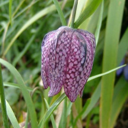

In [8]:
img = PILImage.create(data[0][1])
print(img.size)
img.to_thumb(128)

In [9]:
from fastcore.parallel import *

def f(o): return PILImage.create(o[1]).size
sizes = parallel(f, data, n_workers=8)
pd.Series(sizes).value_counts()

(224, 224)    16465
Name: count, dtype: int64

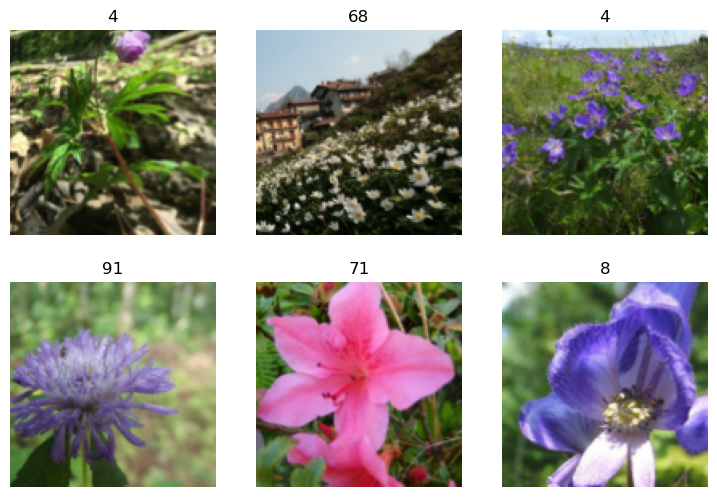

In [10]:
def get_items(*args, **kwargs): return data

get_x = lambda entry: PILImage.create(io.BytesIO(entry[1]))
get_y = lambda entry: entry[0]

block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_items,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=IndexSplitter(range(12753, len(data))),
                  item_tfms=[Resize(192, method='squish')],
                  batch_tfms=[*aug_transforms(size=128, min_scale=0.75)])

dls = block.dataloaders('', bs=64)
dls.show_batch(max_n=6)

In [11]:
from torcheval.metrics.functional import multiclass_f1_score

learn = vision_learner(dls, 'convnext_small_in22k', metrics=multiclass_f1_score, path='.').to_fp16()

/nix/store/i3j0gl8kmy0xly00r8qzjgkfywgbhmz6-python3-3.11.9-env/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

/nix/store/i3j0gl8kmy0xly00r8qzjgkfywgbhmz6-python3-3.11.9-env/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/nix/store/i3j0gl8kmy0xly00r8qzjgkfywgbhmz6-python3-3.11.9-env/lib/python3.11/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


SuggestedLRs(valley=0.0014454397605732083, slide=0.0014454397605732083)

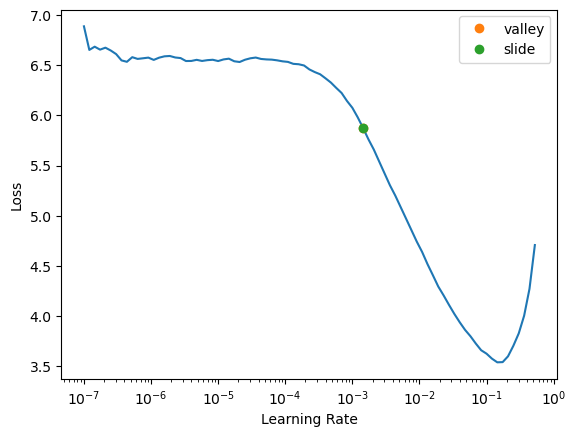

In [12]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
learn.fine_tune(5, 0.001)

epoch,train_loss,valid_loss,multiclass_f1_score,time
0,0.583905,0.441213,0.913793,16:23


epoch,train_loss,valid_loss,multiclass_f1_score,time
0,0.256058,0.241394,0.954203,25:27
1,0.249974,0.305366,0.941810,31:58
2,0.236525,0.282890,0.947198,26:18
3,0.184139,0.272329,0.953933,25:09


In [ ]:
sample_submission = pd.read_csv(path/'sample_submission.csv')
sample_submission